<a href="https://www.kaggle.com/code/officialaa/final-ipynb?scriptVersionId=194468192" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd

url="https://raw.githubusercontent.com/sap03rocks/mimic_lstm/main/try1_noise_ppg.csv"
# Read the data into a DataFrame
data = pd.read_csv(url, header=None)
data = data.drop(columns=[0,1])
data

,2
0,noise_ppg
1,-0.3034266852089068
2,-0.3428809101974344
3,-0.26194846766170776
4,-0.3253858686315971
...,...
4996,0.07393441683526092
4997,0.10750169333199508
4998,0.0875841114886792
4999,0.2067616318891087


In [3]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional, Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Assuming 'data' is already defined and loaded
# Ensure 'data' is a pandas Series
if isinstance(data, pd.DataFrame):
    data = data.iloc[:, 0]  # Select the first column or the relevant column

# Handle non-numeric values
data = pd.to_numeric(data, errors='coerce')
data = data.dropna()

# Reshape and scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))

# Function to create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 8
X, y = create_sequences(scaled_data, seq_length)

# Reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define model
model = Sequential()
model.add(Input(shape=(seq_length, n_features)))
model.add(Bidirectional(LSTM(200, return_sequences=True, activation='relu')))
model.add(Bidirectional(LSTM(100, return_sequences=True, activation='relu')))
model.add(Bidirectional(LSTM(100, return_sequences=True, activation='relu')))
model.add(Bidirectional(LSTM(50, return_sequences=False, activation='relu')))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Summarize model
model.summary()


2024-08-28 18:49:52.771736: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-28 18:49:52.771854: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-28 18:49:52.899725: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 8, 400)         │       323,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 8, 200)         │       400,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 8, 200)         │       240,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 100)            │       100,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,065,301 (4.06 MB)

 Trainable params: 1,065,301 (4.06 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
history=model.fit(X, y, epochs=40, batch_size=1, validation_split=0.2)
results = model.evaluate(X_test, y_test, batch_size=1)
print("Test loss:", results)

Epoch 1/40
  14/3993 ━━━━━━━━━━━━━━━━━━━━ 32s 8ms/step - loss: 0.2036   

I0000 00:00:1724871017.624144     101 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3993/3993 ━━━━━━━━━━━━━━━━━━━━ 47s 9ms/step - loss: 0.0080 - val_loss: 0.0018
Epoch 2/40
3993/3993 ━━━━━━━━━━━━━━━━━━━━ 31s 8ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 3/40
3993/3993 ━━━━━━━━━━━━━━━━━━━━ 32s 8ms/step - loss: 0.0018 - val_loss: 0.0022
Epoch 4/40
3993/3993 ━━━━━━━━━━━━━━━━━━━━ 31s 8ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 5/40
3993/3993 ━━━━━━━━━━━━━━━━━━━━ 31s 8ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 6/40
3993/3993 ━━━━━━━━━━━━━━━━━━━━ 32s 8ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 7/40
3993/3993 ━━━━━━━━━━━━━━━━━━━━ 31s 8ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 8/40
3993/3993 ━━━━━━━━━━━━━━━━━━━━ 31s 8ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 9/40
3993/3993 ━━━━━━━━━━━━━━━━━━━━ 32s 8ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 10/40
3993/3993 ━━━━━━━━━━━━━━━━━━━━ 31s 8ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 11/40
3993/3993 ━━━━━━━━━━━━━━━━━━━━ 31s 8ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 12/40
3993/3993 ━━━━━━━━

In [5]:
# Assuming you have already trained your LSTM model
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X, y, batch_size=1)
print("Test loss, test accuracy:", results)

# Generate predictions (probabilities) on new data using `predict`
print("Generate predictions for 3 samples")
predictions = model.predict(X[:3])
print("Predictions shape:", predictions.shape)

Evaluate on test data
4992/4992 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0012
Test loss, test accuracy: 0.001185111002996564
Generate predictions for 3 samples
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predictions shape: (3, 1)


W0000 00:00:1724872290.250103     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724872290.250597     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [6]:


# Assuming you have already trained your LSTM model
# Generate predictions for the entire dataset
predictions = model.predict(X)
print(predictions)

# Convert predictions to a DataFrame
predictions_df = pd.DataFrame(predictions, columns=['Prediction'])

# Save the DataFrame to a CSV file
predictions_df.to_csv('predictions.csv', index=False)

print("Predictions saved to predictions.csv")


156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
[[0.24881135]
 [0.24722503]
 [0.24986975]
 ...
 [0.58763313]
 [0.584114  ]
 [0.62452507]]
Predictions saved to predictions.csv


In [7]:
# Predict on the training data
train_predict = model.predict(X_train)

# Predict on the testing data
test_predict = model.predict(X_test)


110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step


110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


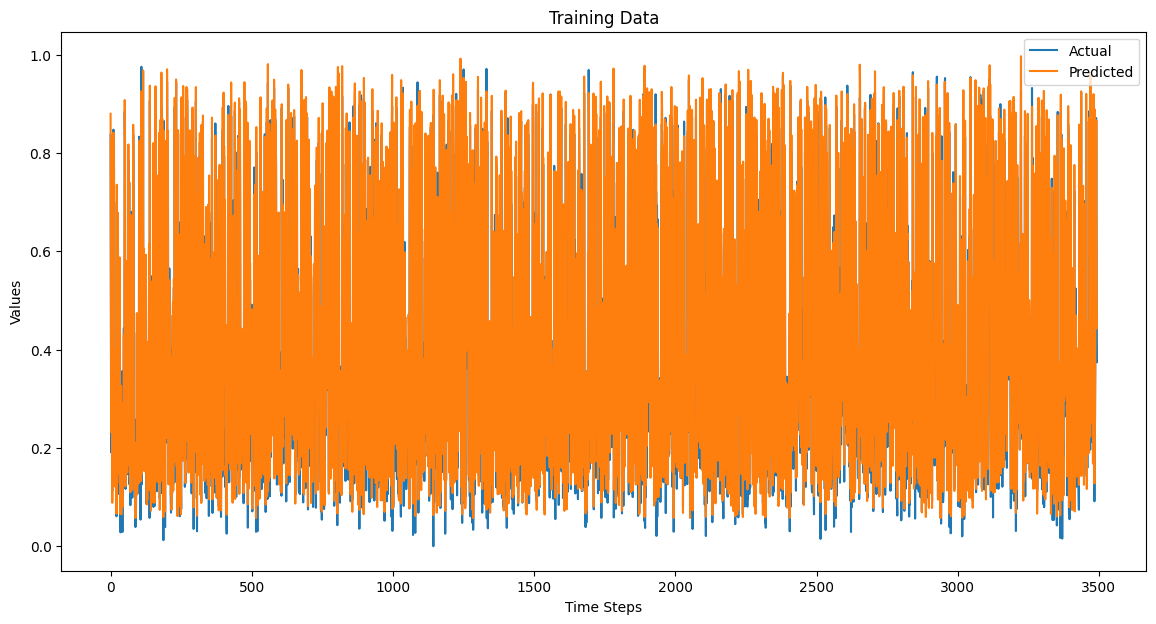

In [8]:
import matplotlib.pyplot as plt

# Predict on the training data
train_predict = model.predict(X_train)

# Predict on the testing data
test_predict = model.predict(X_test)

# Plotting the results
plt.figure(figsize=(14, 7))

# Plot training data

plt.plot(y_train, label='Actual')
plt.plot(train_predict, label='Predicted')
plt.title('Training Data')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend()
plt.show()


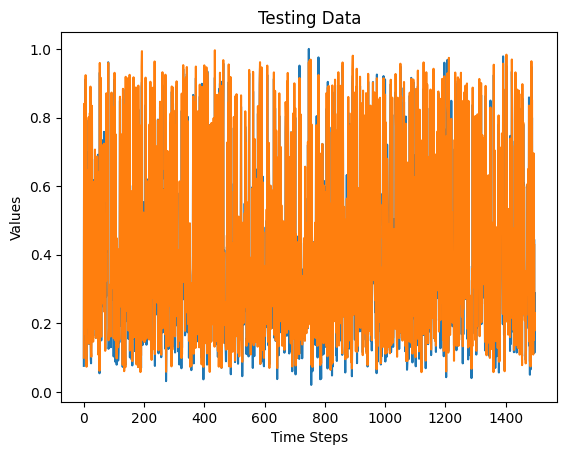

In [9]:
plt.plot(y_test, label='Actual')
plt.plot(test_predict, label='Predicted')
plt.title('Testing Data')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.show()

In [10]:
# Create a DataFrame with actual and predicted values
results_df = pd.DataFrame({
    'Actual': y_test.flatten(),  # Flatten in case y_test is not 1D
    'Predicted': test_predict.flatten()  # Flatten in case test_predict is not 1D
})

# Save the DataFrame to a CSV file
results_df.to_csv('test_vs_actual.csv', index=True)

print("Test vs Actual results saved to test_vs_actual.csv")


Test vs Actual results saved to test_vs_actual.csv


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MSE: 0.002045643202377342
MAE: 0.03609772347829689
R^2: 0.981955843335305


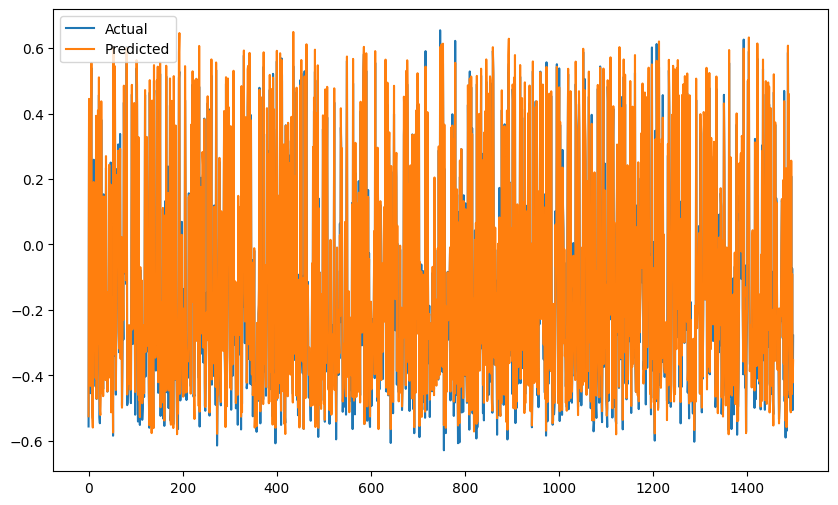

<Figure size 640x480 with 0 Axes>

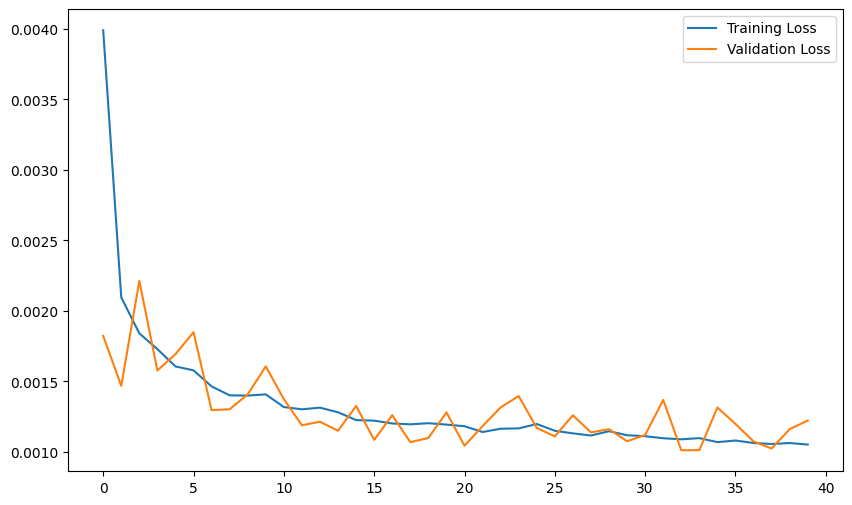

<Figure size 640x480 with 0 Axes>

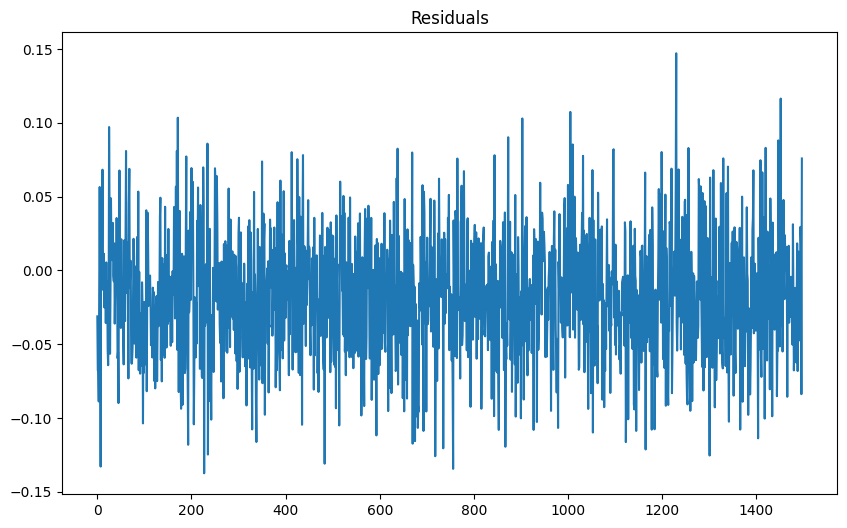

<Figure size 640x480 with 0 Axes>

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# make predictions
y_pred = model.predict(X_test)

# inverse transform predictions
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

# calculate metrics
mse = mean_squared_error(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R^2: {r2}')

# plot predictions vs. actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.legend()
plt.show()
plt.savefig('predictions_vs_actual.png')

# plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()
plt.savefig('training_validation.png')
# plot residuals
residuals = y_test_inv - y_pred_inv
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()
plt.savefig('residual.png')


In [12]:
!pip install reportlab


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 27.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.4/199.4 kB 12.5 MB/s eta 0:00:00


In [13]:
import reportlab
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas

def create_pdf(filename):
    c = canvas.Canvas(filename, pagesize=letter)
    width, height = letter

    # Title
    c.setFont("Helvetica-Bold", 20)
    c.drawString(100, height - 100, "LSTM Prediction Report")

    # Introduction
    c.setFont("Helvetica", 12)
    c.drawString(100, height - 150, "Introduction")
    c.drawString(100, height - 170, "This report presents the results of LSTM predictions...")

    # Predictions and Actual Values
    c.drawString(100, height - 200, "Predictions and its respective actual values")
    plot_path = "/kaggle/working/predictions_vs_actual.png"
    c.drawImage(plot_path, 100, height - 500, width=400, height=300)

    # Training and Validation
    c.drawString(100, height - 820, "Training and validation")
    plot_path = "/kaggle/working/training_validation.png"
    c.drawImage(plot_path, 100, height - 1120, width=400, height=300)

    # Residual
    c.drawString(100, height - 1440, "Residual")
    plot_path = "/kaggle/working/residual.png"
    c.drawImage(plot_path, 100, height - 1740, width=400, height=300)

    c.save()

create_pdf("LSTM_Prediction_Report.pdf")


In [14]:
!pip install python-docx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 5.8 MB/s eta 0:00:00a 0:00:01


<a href="/kaggle/working/test_vs_actual.csv"> Download File </a>